In [4]:
using Gen,PyPlot,Statistics, StatsPlots

## Introduction

Our goal is to implement agents that compute rational *policies*. Policies are *plans* for achieving good outcomes in environments where:

- The agent makes a *sequence* of *distinct* choices, rather than choosing once.

- The environment is *stochastic* (or "random").

- Some features of the environment are initially *unknown* to the agent. (So the agent may choose to gain information in order to improve future decisions.)

This section begins with agents that solve the very simplest decision problems. These are trivial *one-shot* problems, where the agent selects a single action (not a sequence of actions). We use WebPPL to solve these problems in order to illustrate the core concepts that are necessary for the more complex problems in later chapters.

<a id="planning_as"></a>

## One-shot decisions in a deterministic world

In a *one-shot decision problem* an agent makes a single choice between a set of *actions*, each of which has potentially distinct *consequences*. A rational agent chooses the action that is best in terms of his or her own preferences. Often, this depends not on the *action* itself being preferred, but only on its *consequences*. 

For example, suppose Tom is choosing between restaurants and all he cares about is eating pizza. There's an Italian restaurant and a French restaurant. Tom would choose the French restaurant if it offered pizza. Since it does *not* offer pizza, Tom will choose the Italian.

Tom selects an action $a \in A$ from the set of all actions. The actions in this case are {"eat at Italian restaurant", "eat at French restaurant"}. The consequences of an action are represented by a transition function $T \colon S \times A \to S$ from state-action pairs to states. In our example, the relevant *state* is whether or not Tom eats pizza. Tom's preferences are represented by a real-valued utility function $U \colon S \to \mathbb{R}$, which indicates the relative goodness of each state. 

Tom's *decision rule* is to take action $a$ that maximizes utility, i.e., the action

$
{\arg \max}_{a \in A} U(T(s,a))
$

In WebPPL, we can implement this utility-maximizing agent as a function `maxAgent` that takes a state $s \in S$ as input and returns an action. For Tom's choice between restaurants, we assume that the agent starts off in a state `"initialState"`, denoting whatever Tom does before going off to eat. The program directly translates the decision rule above using the higher-order function `argMax`.

In [12]:
# Choose to eat at the Italian or French restaurants
actions = ["italian", "french"]
states = ["pizza","steak frites"]
PIZZA = 1
STEAK_FRITES = 2
function transition(state,action)
    if action == "italian"
        return PIZZA
    else
        return STEAK_FRITES
    end
end

function utility(state)
    if state == PIZZA
        return 10
    else
        return 0
    end
end;

In [13]:
function max_agent(state)
    return argmax(action -> utility(transition(state,action)),actions)
end;

In [14]:
max_action = max_agent(:initial_state)
print("choice in initial state: $max_action");

choice in initial state: italian

>**Exercise**: Which parts of the code can you change in order to make the agent choose the French restaurant?

There is an alternative way to compute the optimal action for this problem. The idea is to treat choosing an action as an *inference* problem. The previous chapter showed how we can *infer* the probability that a coin landed Heads from the observation that two of three coins were Heads.

In [15]:
@gen function heads()
    a = @trace(bernoulli(0.5), :a)
    b = @trace(bernoulli(0.5), :b)
    c = @trace(bernoulli(0.5), :c)
    @trace(normal(a + b + c, 0.01), :sum)
end

function infer_heads(sum,amount_of_computation)
    observations = Gen.choicemap()
    observations[:sum] = sum
    trace, = Gen.generate(heads,(),observations)
    as = []
    for i = 1:1000
        trace, = Gen.mh(trace, select(:a, :b, :c))
        push!(as, trace[:a])
    end
    return as
end;

0.654
Your GR installation is incomplete. Rerunning build step for GR package.


┌ Error: Error importing GR_jll:
│   err = InitError(:Qt5Base_jll, ErrorException("could not load library \"C:\\Users\\Roie\\.julia\\artifacts\\2ca1bc23171a906b0de66ce0428f60b84d91e2e3\\bin\\Qt5Concurrent.dll\"\nThe specified procedure could not be found. "))
└ @ GR C:\Users\Roie\.julia\packages\GR\4DHy8\src\funcptrs.jl:42
┌ Info: Switching provider to GR due to error in depsfile
│   depsfile = C:\Users\Roie\.julia\packages\GR\4DHy8\deps\deps.jl
└ @ GR C:\Users\Roie\.julia\packages\GR\4DHy8\src\GR.jl:349
┌ Info: Emptying depsfile. GR provider is GR
│   provider = GR
│   depsfile = C:\Users\Roie\.julia\packages\GR\4DHy8\deps\deps.jl
└ @ GR.Builder C:\Users\Roie\.julia\packages\GR\4DHy8\deps\build.jl:128
┌ Info: Downloading pre-compiled GR 0.57.3 Windows binary
└ @ GR.Builder C:\Users\Roie\.julia\packages\GR\4DHy8\deps\build.jl:193


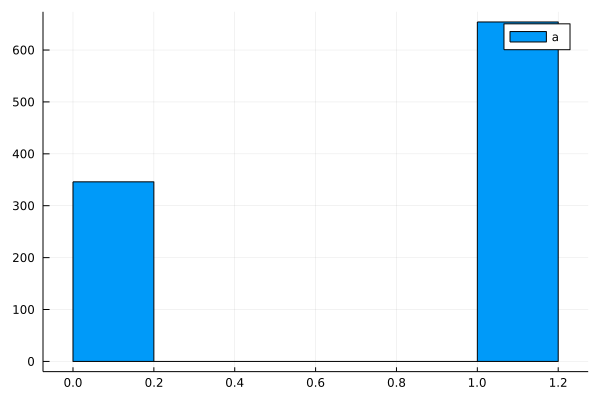

┌ Info: GR was successfully rebuilt
└ @ GR C:\Users\Roie\.julia\packages\GR\4DHy8\src\GR.jl:358


In [9]:
as = infer_heads(2,1000)
println(mean(as));
histogram(as, label="a")

The same inference machinery can compute the optimal action in Tom's decision problem. We sample random actions with `uniformDraw` and condition on the preferred outcome happening. Intuitively, we imagine observing the consequence we prefer (e.g. pizza) and then *infer* from this the action that caused this consequence. <!-- address evidential vs causal decision theory? -->

This idea is known as "planning as inference" ([Botvinick and Toussaint, 2012](https://scholar.google.com/scholar?q=%22Planning%20as%20Inference%22)). It also resembles the idea of "backwards chaining" in logical inference and planning. The `inferenceAgent` solves the same problem as `maxAgent`, but uses planning as inference: 

In [10]:
@gen function inference_agent(state)
    action_index = @trace(uniform_discrete(1,length(actions)),:action_index)
    @trace(normal(transition(state,actions[action_index]), 0.01), :state)
end;

function infer_inference_agent(state)
    observations = Gen.choicemap()
    observations[:state] = state
    trace, = Gen.generate(inference_agent,(:initial_state,),observations)
    action_indices = []
    for i = 1:1000
        trace, = Gen.mh(trace, select(:action_index))
        push!(action_indices, trace[:action_index])
    end
    return action_indices
end;

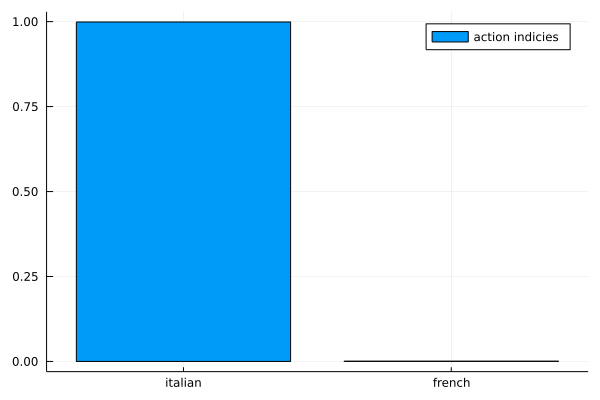

In [11]:
action_indices = infer_inference_agent(PIZZA)
occurences=Dict([(action,count(x->actions[x]==action,action_indices)) for action in actions])
StatsPlots.bar(actions,[occurences["italian"]/1000,occurences["french"]/1000],label="action indicies")

>**Exercise**: Change the agent's goals so that they choose the French restaurant.

## One-shot decisions in a stochastic world

In the previous example, the transition function from state-action pairs to states was *deterministic* and so described a deterministic world or environment. Moreover, the agent's actions were deterministic; Tom always chose the best action ("Italian"). In contrast, many examples in this tutorial will involve a *stochastic* world and a noisy "soft-max" agent. 

Imagine that Tom is choosing between restaurants again. This time, Tom's preferences are about the overall quality of the meal. A meal can be "bad", "good" or "spectacular" and each restaurant has good nights and bad nights. The transition function now has type signature $ T\colon S \times A \to \Delta S $, where $\Delta S$ represents a distribution over states. Tom's decision rule is now to take the action $a \in A$ that has the highest *average* or *expected* utility, with the expectation $\mathbb{E}$ taken over the probability of different successor states $s' \sim T(s,a)$:

$
\max_{a \in A} \mathbb{E}( U(T(s,a)) )
$

To represent this in WebPPL, we extend `maxAgent` using the `expectation` function, which maps a distribution with finite support to its (real-valued) expectation:

In [ ]:
#TODO: write maxEUAgent

>**Exercise**: Adjust the transition probabilities such that the agent chooses the Italian Restaurant.

The `inferenceAgent`, which uses the planning-as-inference idiom, can also be extended using `expectation`. Previously, the agent's action was conditioned on leading to the best consequence ("pizza"). This time, Tom is not aiming to choose the action most likely to have the best outcome. Instead, he wants the action with better outcomes on average. This can be represented in `inferenceAgent` by switching from a `condition` statement to a `factor` statement. The `condition` statement expresses a "hard" constraint on actions: actions that fail the condition are completely ruled out. The `factor` statement, by contrast, expresses a "soft" condition. Technically, `factor(x)` adds `x` to the unnormalized log-probability of the program execution within which it occurs.

To illustrate `factor`, consider the following variant of the `twoHeads` example above. Instead of placing a hard constraint on the total number of Heads outcomes, we give each setting of `a`, `b` and `c` a *score* based on the total number of heads. The score is highest when all three coins are Heads, but even the "all tails" outcomes is not ruled out completely.

In [ ]:
#TODO: write softHeads

As another example, consider the following short program:

In [ ]:
#TODO: write extra example

Without the `factor` statement, each value of the variable `n` has equal probability. Adding the `factor` statements adds `n*n` to the log-score of each value. To get the new probabilities induced by the `factor` statement we compute the normalizing constant given these log-scores. The resulting probability $P(y=2)$ is:

$
P(y=2) = \frac {e^{2 \cdot 2}} { (e^{0 \cdot 0} + e^{1 \cdot 1} + e^{2 \cdot 2}) }
$

Returning to our implementation as planning-as-inference for maximizing *expected* utility, we use a `factor` statement to implement soft conditioning:

In [ ]:
#TODO: write softmaxAgent

The `softMaxAgent` differs in two ways from the `maxEUAgent` above. First, it uses the planning-as-inference idiom. Second, it does not deterministically choose the action with maximal expected utility. Instead, it implements *soft* maximization, selecting actions with a probability that depends on their expected utility. Formally, let the agent's probability of choosing an action be $C(a;s)$ for $a \in A$ when in state $s \in S$. Then the *softmax* decision rule is:

$
C(a; s) \propto e^{\alpha \mathbb{E}(U(T(s,a))) }
$

The noise parameter $\alpha$ modulates between random choice $(\alpha=0)$ and the perfect maximization $(\alpha = \infty)$ of the `maxEUAgent`.

Since rational agents will *always* choose the best action, why consider softmax agents? One of the goals of this tutorial is to infer the preferences of agents (e.g. human beings) from their choices. People do not always choose the normatively rational actions. The softmax agent provides a simple, analytically tractable model of sub-optimal choice[^softmax], which has been tested empirically on human action selection refp:luce2005individual. Moreover, it has been used extensively in Inverse Reinforcement Learning as a model of human errors refp:kim2014inverse, refp:zheng2014robust. For this reason, we employ the softmax model throughout this tutorial. When modeling an agent assumed to be optimal, the noise parameter $\alpha$ can be set to a large value. <!-- [TODO: Alternatively, agent could output dist.MAP().val instead of dist.] -->

[^softmax]: A softmax agent's choice of action is a differentiable function of their utilities. This differentiability makes possible certain techniques for inferring utilities from choices.